### get data

In [18]:
%cd /home/nuat/projects/fractal-defi
from examples.funding_rate_forecasting.utils.get_data import (
    get_list_top_n_tickers, 
    download_spot_future_fr_data
)
from examples.funding_rate_forecasting.utils.process_data import (
    process_ticker
)
from examples.funding_rate_forecasting.utils.create_features import (
    extract_time_series_features
)

/home/nuat/projects/fractal-defi


In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
current_time = datetime(
    year = 2025, 
    month = 4, 
    day = 16
)
years = 1
delta = timedelta(days=365 * years)
start_time = current_time - delta

In [20]:
list_top_n_tickers = get_list_top_n_tickers(0)

download_spot_future_fr_data(
    futures_spot_tickers=list_top_n_tickers, 
    start_timestamp=start_time,
    end_timstamp=current_time,
    interval='1h'
)

0it [00:00, ?it/s]


### process data

In [23]:
data = {}
for ticker in tqdm(list_top_n_tickers):
    df_tmp = process_ticker(ticker)
    data[ticker] = df_tmp

0it [00:00, ?it/s]


In [24]:
features_list = []
tickers = []

for ticker, df in data.items():

    if df.shape[0]:
        train_size = int(df.shape[0] * 0.8)
        df = df.iloc[1:train_size]
        df = df.iloc[7::8]

        if df.shape[0] <= 300:
            print(ticker)
            continue

        fr_series = df['fundingRate']
        feats = extract_time_series_features(fr_series)

        if feats:
            features_list.append(feats)
            tickers.append(ticker)
    else:
        print(ticker)

features_df = pd.DataFrame(features_list, index=tickers)

In [ ]:
features_df.head()

### clusters

Два варианта кластеризации:
1. по фичам, извлеченным из funding rate
2. по рыночным индикаторам, извлеченным из цены актива (относительные, как MFI, RSI и т.д.)

In [ ]:
sns.clustermap(features_df['sign_changes'], cmap="vlag", col_cluster=False)
# plt.savefig('images/heatmap_sign_changes.png')

In [ ]:
sns.clustermap(features_df['mean_abs_change'], cmap="vlag", col_cluster=False)
# plt.savefig('images/heatmap_mean_fr_change.png')

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(features_df)

plt.figure(figsize=(14, 14))

sns.scatterplot(x=components[:,0], y=components[:,1], hue=features_df.index.to_list())
for i, ticker in enumerate(features_df.index):
    plt.text(components[i,0], components[i,1], ticker, fontsize=8)

plt.savefig('images/clusters_PCA.png')

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

features_df['cluster'] = cluster_labels

In [ ]:
embedding = TSNE(n_components=2, random_state=42).fit_transform(features_scaled)

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette='tab10')
for i, ticker in enumerate(tickers):
    plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.6)
plt.title("Funding Rate Clusters (TSNE Projection)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster", loc='best')
plt.tight_layout()
plt.savefig('images/clusters_TSNE_KMeans.png')
plt.show()

In [ ]:
def plot_clusters(embedding, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', legend='full')
    for i, ticker in enumerate(tickers):
        plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.5)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()
    plt.show()

In [ ]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=1.2, min_samples=3)
db_labels = dbscan.fit_predict(features_scaled)
plot_clusters(embedding, db_labels, "DBSCAN Clustering")

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=3)
hdb_labels = hdb.fit_predict(features_scaled)
plot_clusters(embedding, hdb_labels, "HDBSCAN Clustering")

# --- Agglomerative Clustering ---
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(features_scaled)
plot_clusters(embedding, agg_labels, "Agglomerative Clustering")

# --- Spectral Clustering ---
spectral = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=42)
spectral_labels = spectral.fit_predict(features_scaled)
plot_clusters(embedding, spectral_labels, "Spectral Clustering")

## trash

In [7]:
df['open_time'] = df['open_time'].str[:-6]
df.sort_values(by='open_time', ascending=False, inplace=True)

df.drop(columns=['ticker'], inplace=True)

df['open_futr_spot_diff'] = df['open_futr'] - df['open_spot']

In [8]:
tmp = df[df['fundingRate'].notna()]

np.corrcoef(tmp.fundingRate, tmp.open_futr_spot_diff)

array([[1.        , 0.61572545],
       [0.61572545, 1.        ]])

In [9]:
df['fundingRate'].ffill(inplace=True)

/tmp/ipykernel_43335/4279684744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fundingRate'].ffill(inplace=True)


In [10]:
df.dropna(inplace=True)

In [11]:
df['open_futr_spot_relative_percentage_diff'] = df['open_futr_spot_diff'] / df['open_futr'] * 100

In [12]:
tmp = df[df['fundingRate'].notna() & (df['fundingRate'] < 0.0001)]

np.corrcoef(tmp.fundingRate, tmp.open_futr_spot_diff)

array([[1.       , 0.1199426],
       [0.1199426, 1.       ]])

In [13]:
df.sort_values(by='open_time', ascending=True, inplace=True)

train_size = int(df.shape[0] * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [46]:
def get_ARIMA_forecast(train_data):
    model = SARIMAX(
        train_data,
        order=(2, 0, 0),  # (p, d, q): AR(5)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    forecast = result.get_forecast(steps=1)
    predicted_mean = forecast.predicted_mean
    return predicted_mean

target = 'open_futr_spot_relative_percentage_diff'
history = list(train[target])
preds = []
for t in tqdm(range(len(test))):
    forecast = get_ARIMA_forecast(history)
    preds.append(forecast[0])
    history.append(test[target].iloc[t])

100%|██████████| 1751/1751 [06:32<00:00,  4.46it/s]


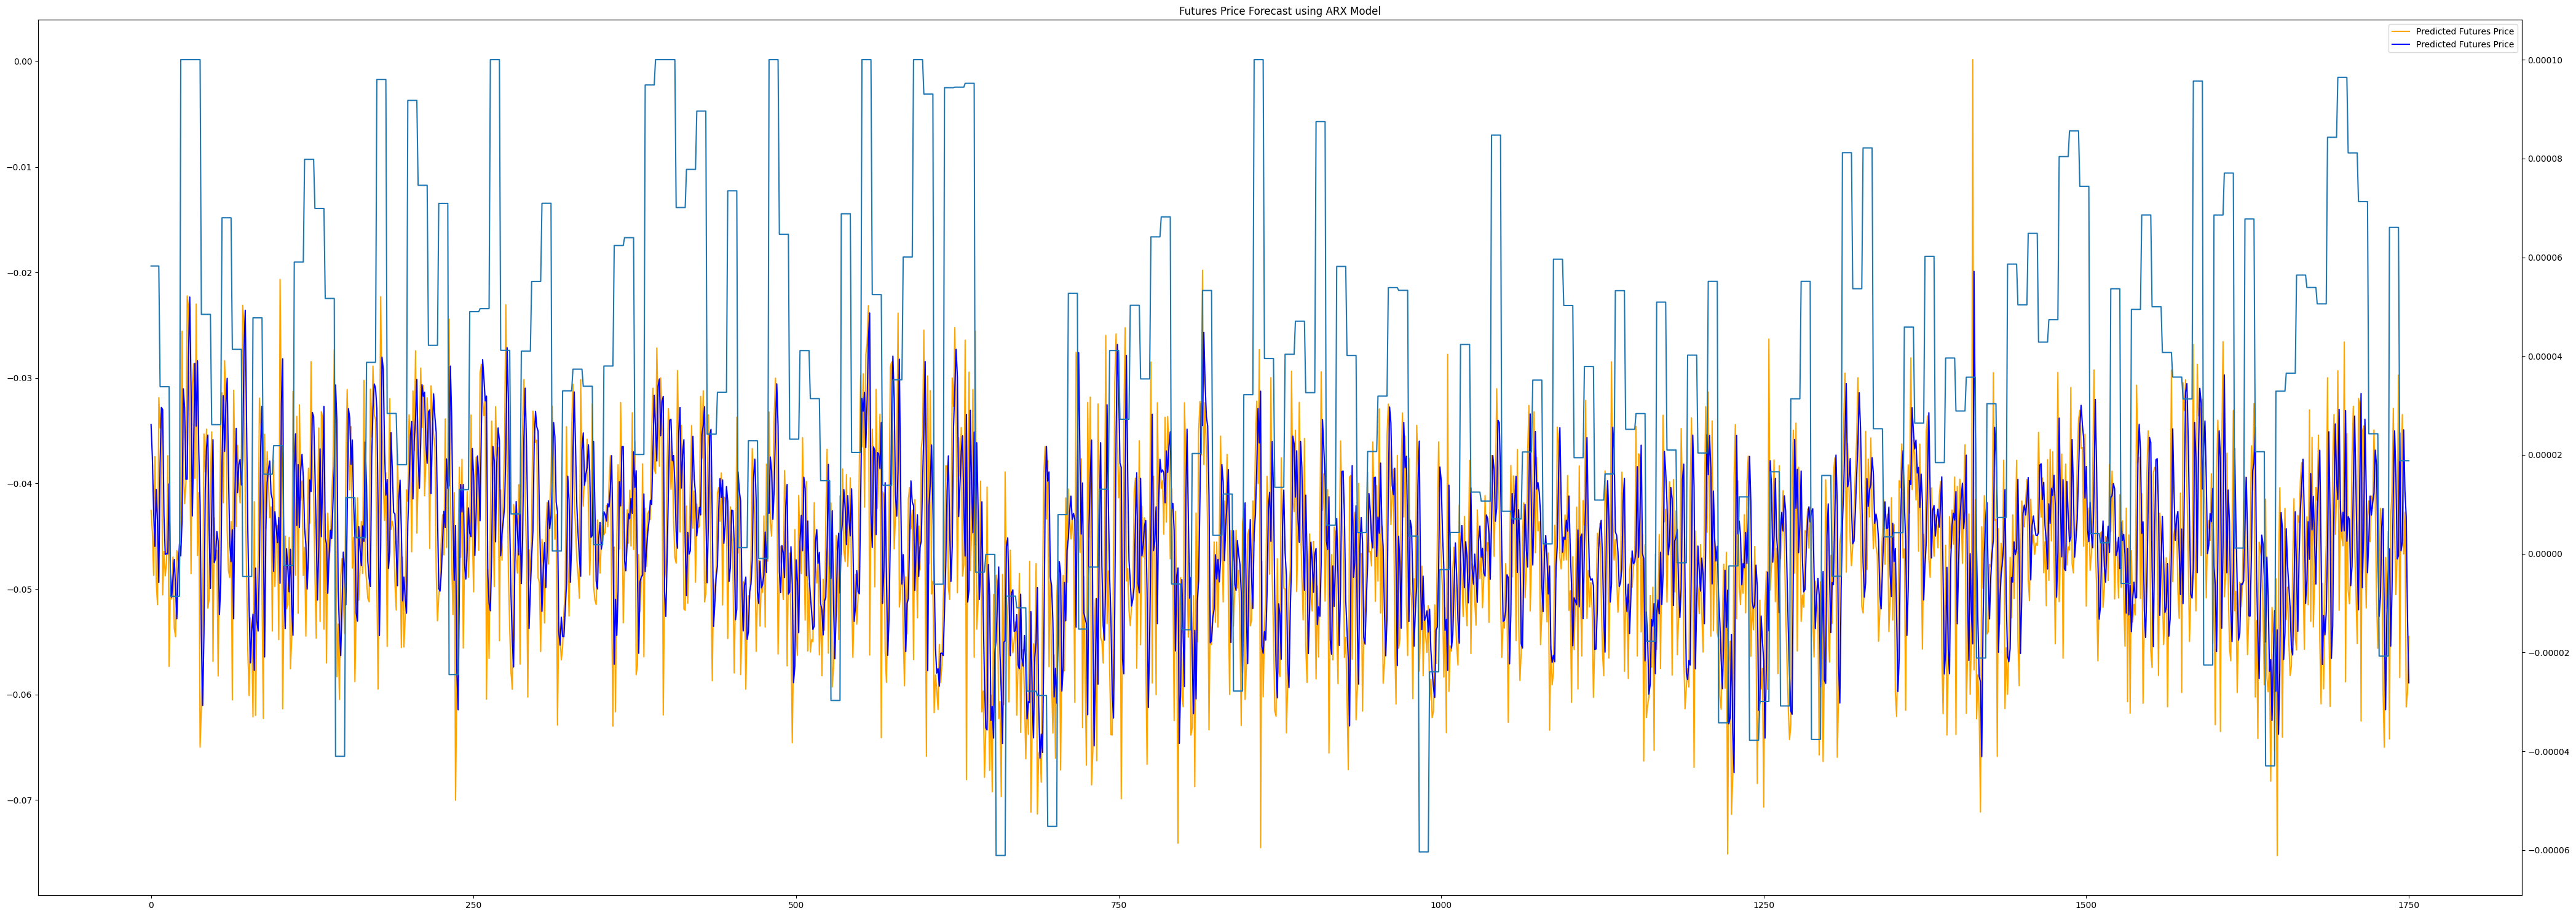

In [54]:
n = len(preds)
true_label = test.open_futr_spot_relative_percentage_diff.iloc[:n]

fig, ax = plt.subplots(1, 1, figsize=(42, 15))
ax.plot(range(n), true_label, label='Predicted Futures Price', color='orange')
ax.plot(range(n), preds, label='Predicted Futures Price', color='blue')
ax1 = ax.twinx()
ax1.plot(range(n), test.fundingRate)
ax.set_title('Futures Price Forecast using ARX Model')
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(true_label, preds)

0.3661969442033697

In [42]:
train['bin_percentage_diff'] = pd.qcut(train['open_futr_spot_relative_percentage_diff'], q=20)

In [45]:
train.groupby('bin_percentage_diff')['fundingRate'].mean().to_frame()

,fundingRate
bin_percentage_diff,
"(-0.0992, -0.06]",-0.000001
"(-0.06, -0.0558]",0.000016
"(-0.0558, -0.0525]",0.000029
"(-0.0525, -0.05]",0.000030
"(-0.05, -0.0478]",0.000040
"(-0.0478, -0.0457]",0.000045
"(-0.0457, -0.0438]",0.000048
"(-0.0438, -0.0419]",0.000056
"(-0.0419, -0.0397]",0.000062
